In [916]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import binom
from scipy.interpolate import interp1d

from utils import *

In [917]:
handler = Signal_Handler()
display = Signal_Display()

# Задание 1

In [918]:
def running_mean(signal: np.ndarray, k: int):
       
    signal = np.pad(signal, (k, k), mode = 'edge')

    return np.array([1 / (2 * k + 1) * np.sum(signal[i - k : i + k]) 
                     for i in range(k, signal.size - k)]) 

In [919]:
x, y, dt = handler.make_signal('rect', interval = (-4, 4), A = 2, w = Converter(T = 2).w)
y += np.random.normal(0, 1, y.size)

In [920]:
k = 15
y_mean = running_mean(y, k = k)

In [921]:
xfft, yfft1 = handler.find_spectrum(y, dt)
yfft2 = handler.find_spectrum(y_mean, dt)[1]

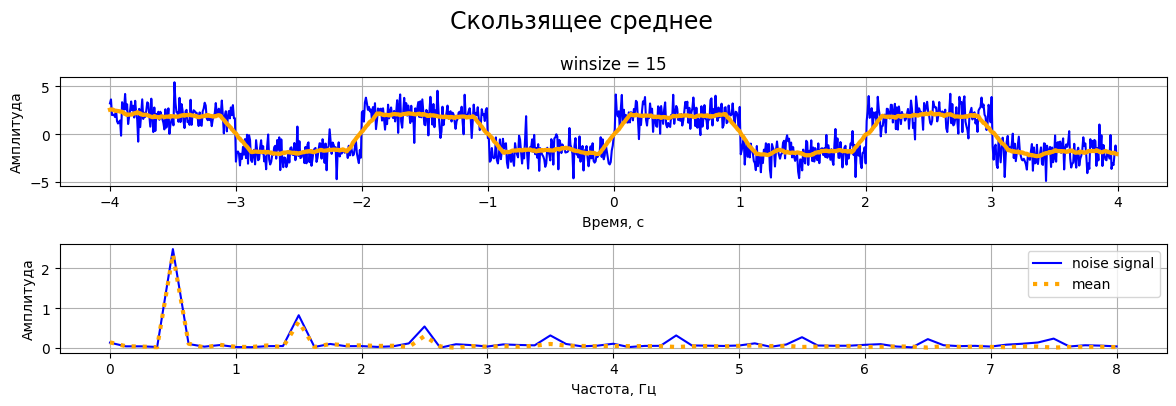

In [922]:
display.clear()

display.make_plot(0, x, y, title = f'winsize = {k}')
display.make_plot(0, x, y_mean, color = 'orange', linewidth = 3)

display.make_plot(1, xfft, yfft1, is_spectrum = True, interval = (0, 8), legend = 'noise signal'),
display.make_plot(1, xfft, yfft2, is_spectrum = True, interval = (0, 8), legend = 'mean',
                  color = 'orange', linestyle = ':', linewidth = 3)

display.plot(title = f'Скользящее среднее')

# Задание 2

In [923]:
def Gaussian_smoothing(time: np.ndarray, signal: np.ndarray, k: int, fwhm: float):
    
    signal = np.pad(signal, (k, k), mode = 'edge')
    g = np.pad(np.exp((-4 * np.log(2) * time ** 2) / fwhm ** 2), 
               (k, k), mode = 'edge')
    
    return np.array([1 / (2 * k + 1) * np.sum(signal[i - k : i + k] * g[i - k : i + k]) 
                     for i in range(k, signal.size - k)])

In [924]:
k = 10
fwhm = 15
y_gauss = Gaussian_smoothing(x, y, k = k, fwhm = fwhm)

In [925]:
xfft, yfft1 = handler.find_spectrum(y, dt)
yfft2 = handler.find_spectrum(y_gauss, dt)[1]

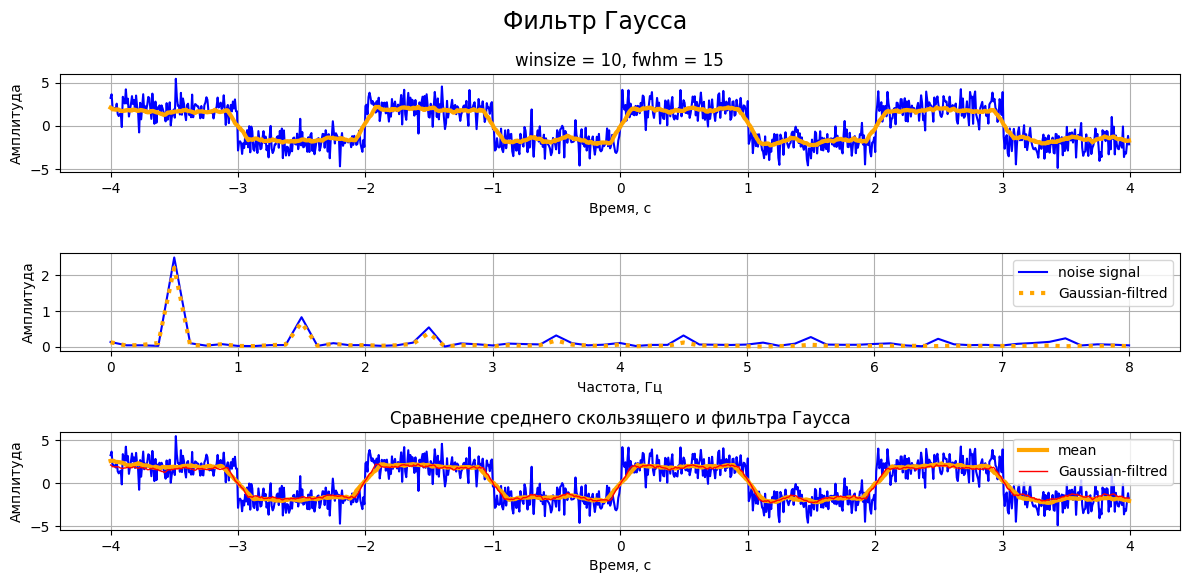

In [926]:
display.clear()

display.make_plot(0, x, y, title = f'winsize = {k}, fwhm = {fwhm}')
display.make_plot(0, x, y_gauss, color = 'orange', linewidth = 3)

display.make_plot(1, xfft, yfft1, is_spectrum = True, interval = (0, 8), legend = 'noise signal')
display.make_plot(1, xfft, yfft2, is_spectrum = True, interval = (0, 8), legend = 'Gaussian-filtred',
                  color = 'orange', linestyle = ':', linewidth = 3)

display.make_plot(2, x, y, title = 'Сравнение среднего скользящего и фильтра Гаусса')
display.make_plot(2, x, y_mean, color = 'orange', linewidth = 3, legend = 'mean')
display.make_plot(2, x, y_gauss, color = 'red', linewidth = 1, legend = 'Gaussian-filtred')

display.plot(title = f'Фильтр Гаусса')

# Задание 3

In [927]:
x = np.linspace(0, 4, num = 250, endpoint = False)
y = np.random.randint(2, size = x.size)

In [928]:
k = 5
fwhm = 20
y_mean = Gaussian_smoothing(x, y, k = k, fwhm = fwhm)

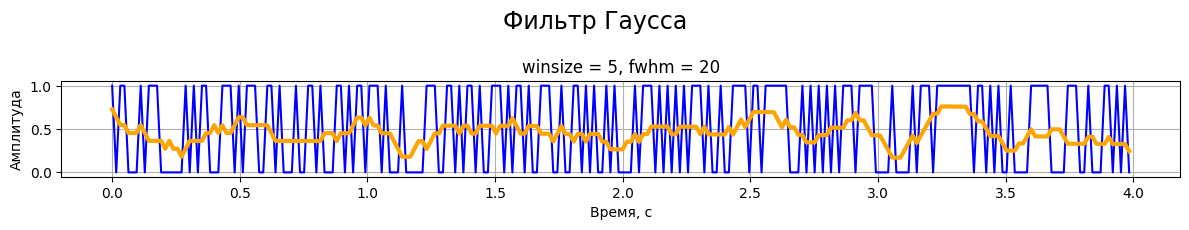

In [929]:
display.clear()

display.make_plot(0, x, y, title = f'winsize = {k}, fwhm = {fwhm}')
display.make_plot(0, x, y_mean, color = 'orange', linewidth = 3)

display.plot(title = f'Фильтр Гаусса')

# Задание 4

In [930]:
def median_filter(signal: np.ndarray, k: int):
    
    signal = np.pad(signal, (k // 2, k // 2), mode = 'edge')
    
    return np.array([np.median(signal[i: i + k]) for i in range(signal.size - k + 1)])               

In [931]:
x, dt = np.linspace(0, 4, num = 250, endpoint = False, retstep = True)
y = np.random.randint(10, size = x.size)

In [932]:
k = 21
y_median = median_filter(y, k = k)

In [933]:
xfft, yfft1 = handler.find_spectrum(y, dt)
yfft2 = handler.find_spectrum(y_median, dt)[1]

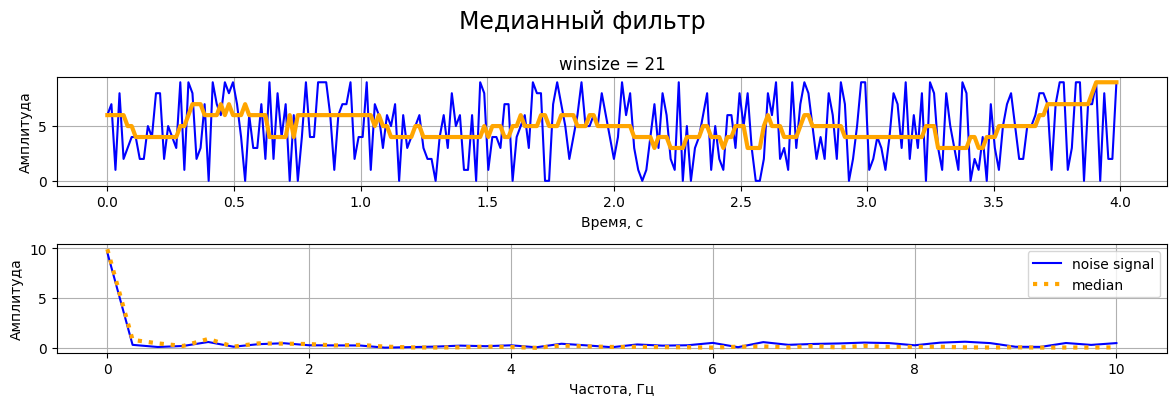

In [934]:
display.clear()

display.make_plot(0, x, y, title = f'winsize = {k}')
display.make_plot(0, x, y_median, color = 'orange', linewidth = 3)

display.make_plot(1, xfft, yfft1, is_spectrum = True, interval = (0, 10), legend = 'noise signal')
display.make_plot(1, xfft, yfft2, is_spectrum = True, interval = (0, 10), legend = 'median',
                  color = 'orange', linestyle = ':', linewidth = 3)

display.plot(title = f'Медианный фильтр')

# Задание 5

In [935]:
def spectral_interpolation(time: np.ndarray, signal: np.ndarray, break_time: tuple, win_size: int):

    handler = Signal_Handler()

    signal1 = signal[time < break_time[0]]
    signal2 = signal[time > break_time[1]]

    yfft1 = handler.find_spectrum(signal1[-win_size:], 1)[1]
    yfft2 = handler.find_spectrum(signal2[:win_size], 1)[1]
    
    yfft = np.mean([yfft1, yfft2], axis = 0, dtype = np.complex128)
    signal_restored = handler.from_spectrum(yfft)

    missing_points = time[(time >= break_time[0]) & (time <= break_time[1])]
    points_num = missing_points.size - signal_restored.size

    link1 = np.interp(missing_points[:points_num // 2], xp = time[time < break_time[0]], fp = signal1)  
    link2 = np.interp(missing_points[-points_num // 2:], xp = time[time > break_time[1]], fp = signal2)

    return np.concatenate([signal1, link1, signal_restored, link2, signal2])

In [936]:
x, y, dt = handler.make_signal('cos', interval = (0, 10), A = 1, w = Converter(f = 2).w)

In [937]:
y_ds = y.copy()
y_ds[(x >= 5) & (x <= 7)] = 0

In [938]:
signal_restored = spectral_interpolation(x, y_ds, (5, 7), 200)

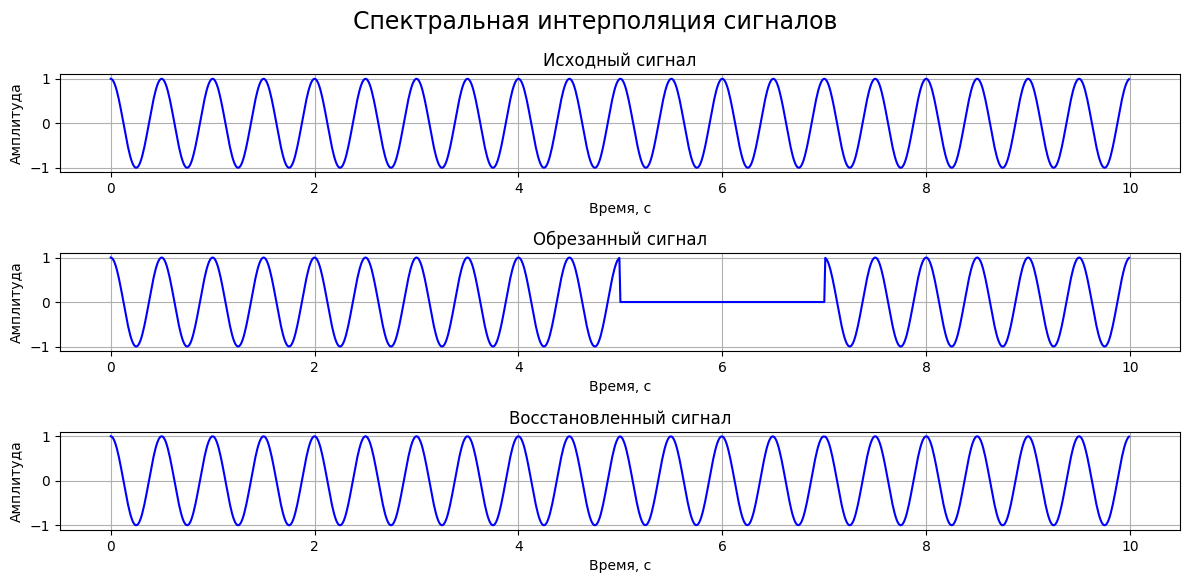

In [939]:
display.clear()

display.make_plot(0, x, y, title = 'Исходный сигнал')
display.make_plot(1, x, y_ds, title = 'Обрезанный сигнал')
display.make_plot(2, x, signal_restored, title = 'Восстановленный сигнал')

display.plot(title = f'Спектральная интерполяция сигналов')

# Задание 6

In [940]:
class Chebyshev_filter:

    def __init__(self, signal: np.ndarray, dt: float):
        handler = Signal_Handler()
        self.xfft, self.yfft = handler.find_spectrum(signal, dt)

    def update_signal(self, signal : np.ndarray, dt: float):
        self.xfft, self.yfft = handler.find_spectrum(signal, dt)

    def H_w(self, w: float, wc: float, eps: float = 0.1, order: int = 2):
        
        x = w / wc

        C = np.array([binom(order, 2 * k) for k in range(order // 2)]).T
        arg1 = np.array([(x ** 2 - 1) ** k for k in range(order // 2)])
        arg2 = np.array([x ** (order - 2 * k) for k in range(order // 2)])

        T = np.sum(C * arg1 * arg2, axis = 0)

        return 1 / np.sqrt(1 + eps ** 2 * T ** 2) 

    def LPF(self, wc: np.ndarray, eps: float = 0.1, order: int = 2):
        return handler.from_spectrum(np.abs(self.H_w(self.xfft, wc, eps, order) * self.yfft))

In [941]:
def downsample(time: np.ndarray, signal: np.ndarray, N: int):
    
    filter = Chebyshev_filter(signal, (time[-1] - time[0]))
    new_fs = time.size / (N * (time[-1] - time[0]))

    return time[::N], filter.LPF(new_fs / 2)[::N]

In [942]:
def upsample(time: np.ndarray, signal: np.ndarray, N: int):
    
    new_time = np.linspace(time[0], time[-1], num = time.size * N)
    new_signal = interp1d(time, signal, kind = 'cubic')

    return new_time, new_signal(new_time)

In [943]:
x, y, dt1 = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 100]).w)
x2, y2, dt2 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 50, A = 1, w = Converter(f = [50, 100]).w)

In [944]:
N = 50
x_ds, y_ds = downsample(x, y, N)
x_us, y_us = upsample(x2, y2, N)

In [945]:
fs_ds = x_ds.size / (x_ds[-1] - x_ds[0])
fs_us = x_us.size / (x_us[-1] - x_us[0])

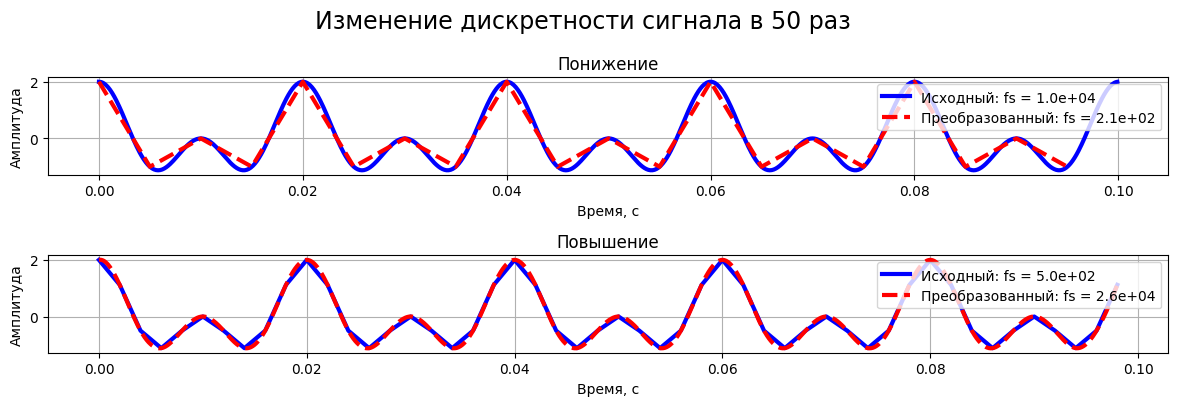

In [946]:
display.clear()

display.make_plot(0, x, y, legend = f'Исходный: fs = {1 / dt1:.1e}', linewidth = 3, title = 'Понижение')
display.make_plot(0, x_ds, y_ds, legend = f'Преобразованный: fs = {fs_ds:.1e}', color = 'red', linestyle = '--', linewidth = 3)

display.make_plot(1, x2, y2, legend = f'Исходный: fs = {1 / dt2:.1e}', linewidth = 3, title = 'Повышение')
display.make_plot(1, x_us, y_us, legend = f'Преобразованный: fs = {fs_us:.1e}', color = 'red', linestyle = '--', linewidth = 3)

display.plot(title = f'Изменение дискретности сигнала в {N} раз')

# Задание 7

In [947]:
x, y, dt1 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 1000, A = 1, w = Converter(f = 50).w)
x2, y2, dt2 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 50, A = 1, w = Converter(f = 50).w)
x3, y3, dt3 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 10, A = 1, w = Converter(f = 50).w)

In [948]:
x1_res, y1_res = downsample(x, y, 10)
x2_res, y2_res = upsample(x2, y2, 2)
x3_res, y3_res = upsample(x3, y3, 9)

In [949]:
fs1_res = x1_res.size / (x1_res[0] - x1_res[-1])
fs2_res = x2_res.size / (x2_res[0] - x2_res[-1])
fs3_res = x3_res.size / (x3_res[0] - x3_res[-1])

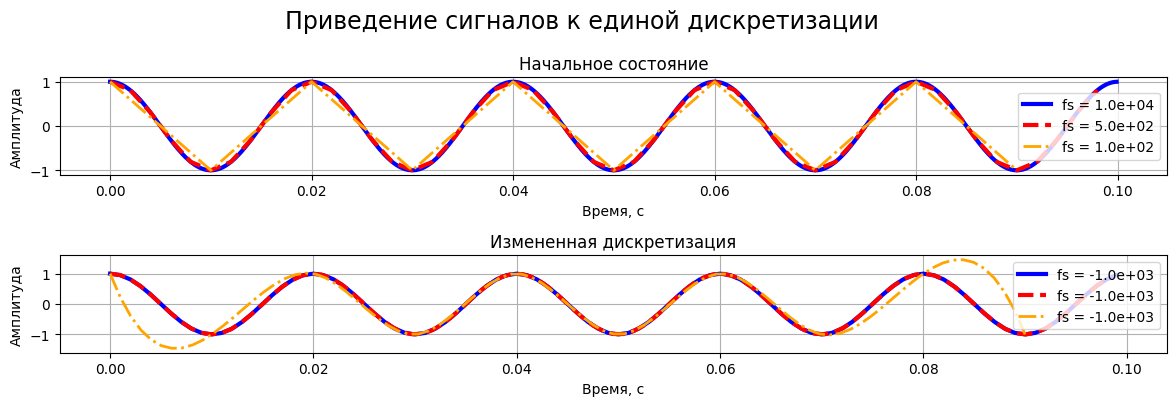

In [950]:
display.clear()

display.make_plot(0, x, y, legend = f'fs = {1 / dt1:.1e}', linewidth = 3, title = 'Начальное состояние')
display.make_plot(0, x2, y2, legend = f'fs = {1 / dt2:.1e}', color = 'red', linestyle = '--', linewidth = 3)
display.make_plot(0, x3, y3, legend = f'fs = {1 / dt3:.1e}', color = 'orange', linestyle = '-.', linewidth = 2)

display.make_plot(1, x1_res, y1_res, linewidth = 3, title = 'Измененная дискретизация', legend = f'fs = {fs1_res:.1e}')
display.make_plot(1, x2_res, y2_res, color = 'red', linestyle = '--', linewidth = 3, legend = f'fs = {fs2_res:.1e}')
display.make_plot(1, x3_res, y3_res, color = 'orange', linestyle = '-.', linewidth = 2, legend = f'fs = {fs3_res:.1e}')

display.plot(title = f'Приведение сигналов к единой дискретизации')